<h4 style="font-family:newtimeroman;font-size:500%;text-align:center;border-radius: 15px 50px;padding: 5px ">Myer-Briggs Personality Type Predicton</h4>

<p style='text-align: right;'>
    <h3>Project By</h3>
        <ul>
             <li>Shynitha Muthyam</li>
             <li>Hrushyang Adloori</li>
             <li>Abhiram Reddy Guduru</li>
        </ul>
</p>

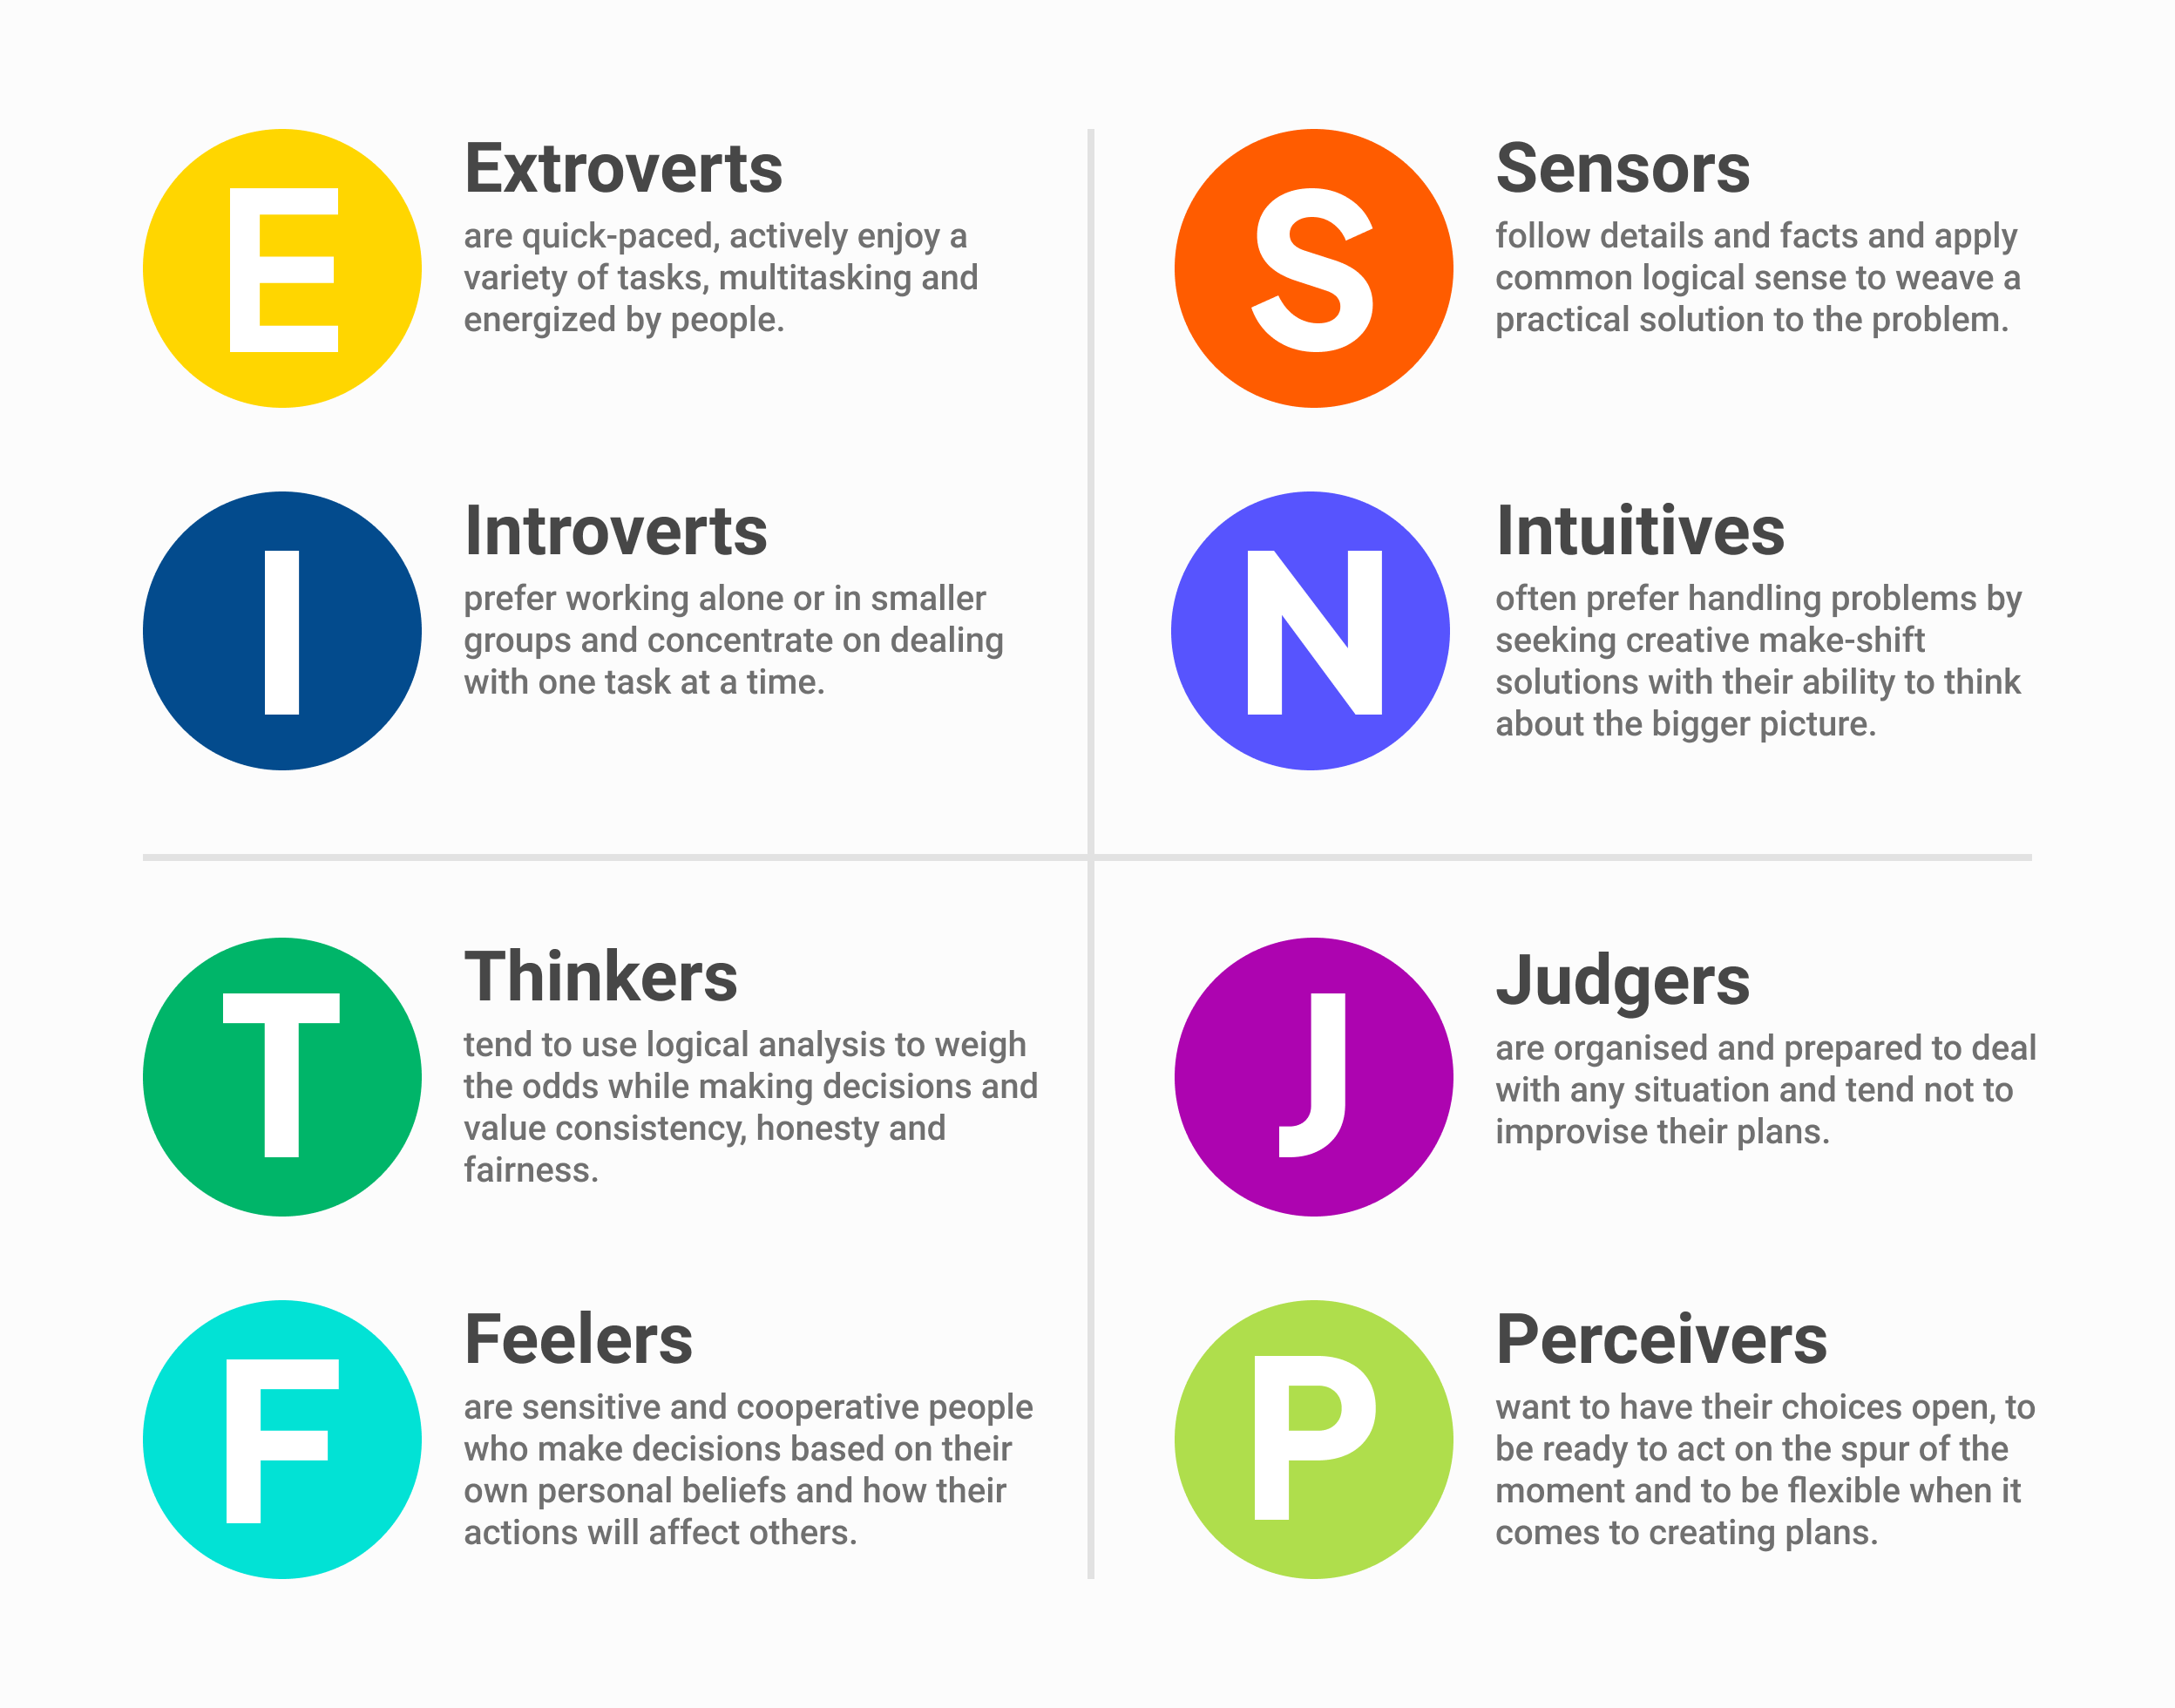

In [37]:
from IPython import display
display.Image("mbti_types1.png",width = 600, height = 600)

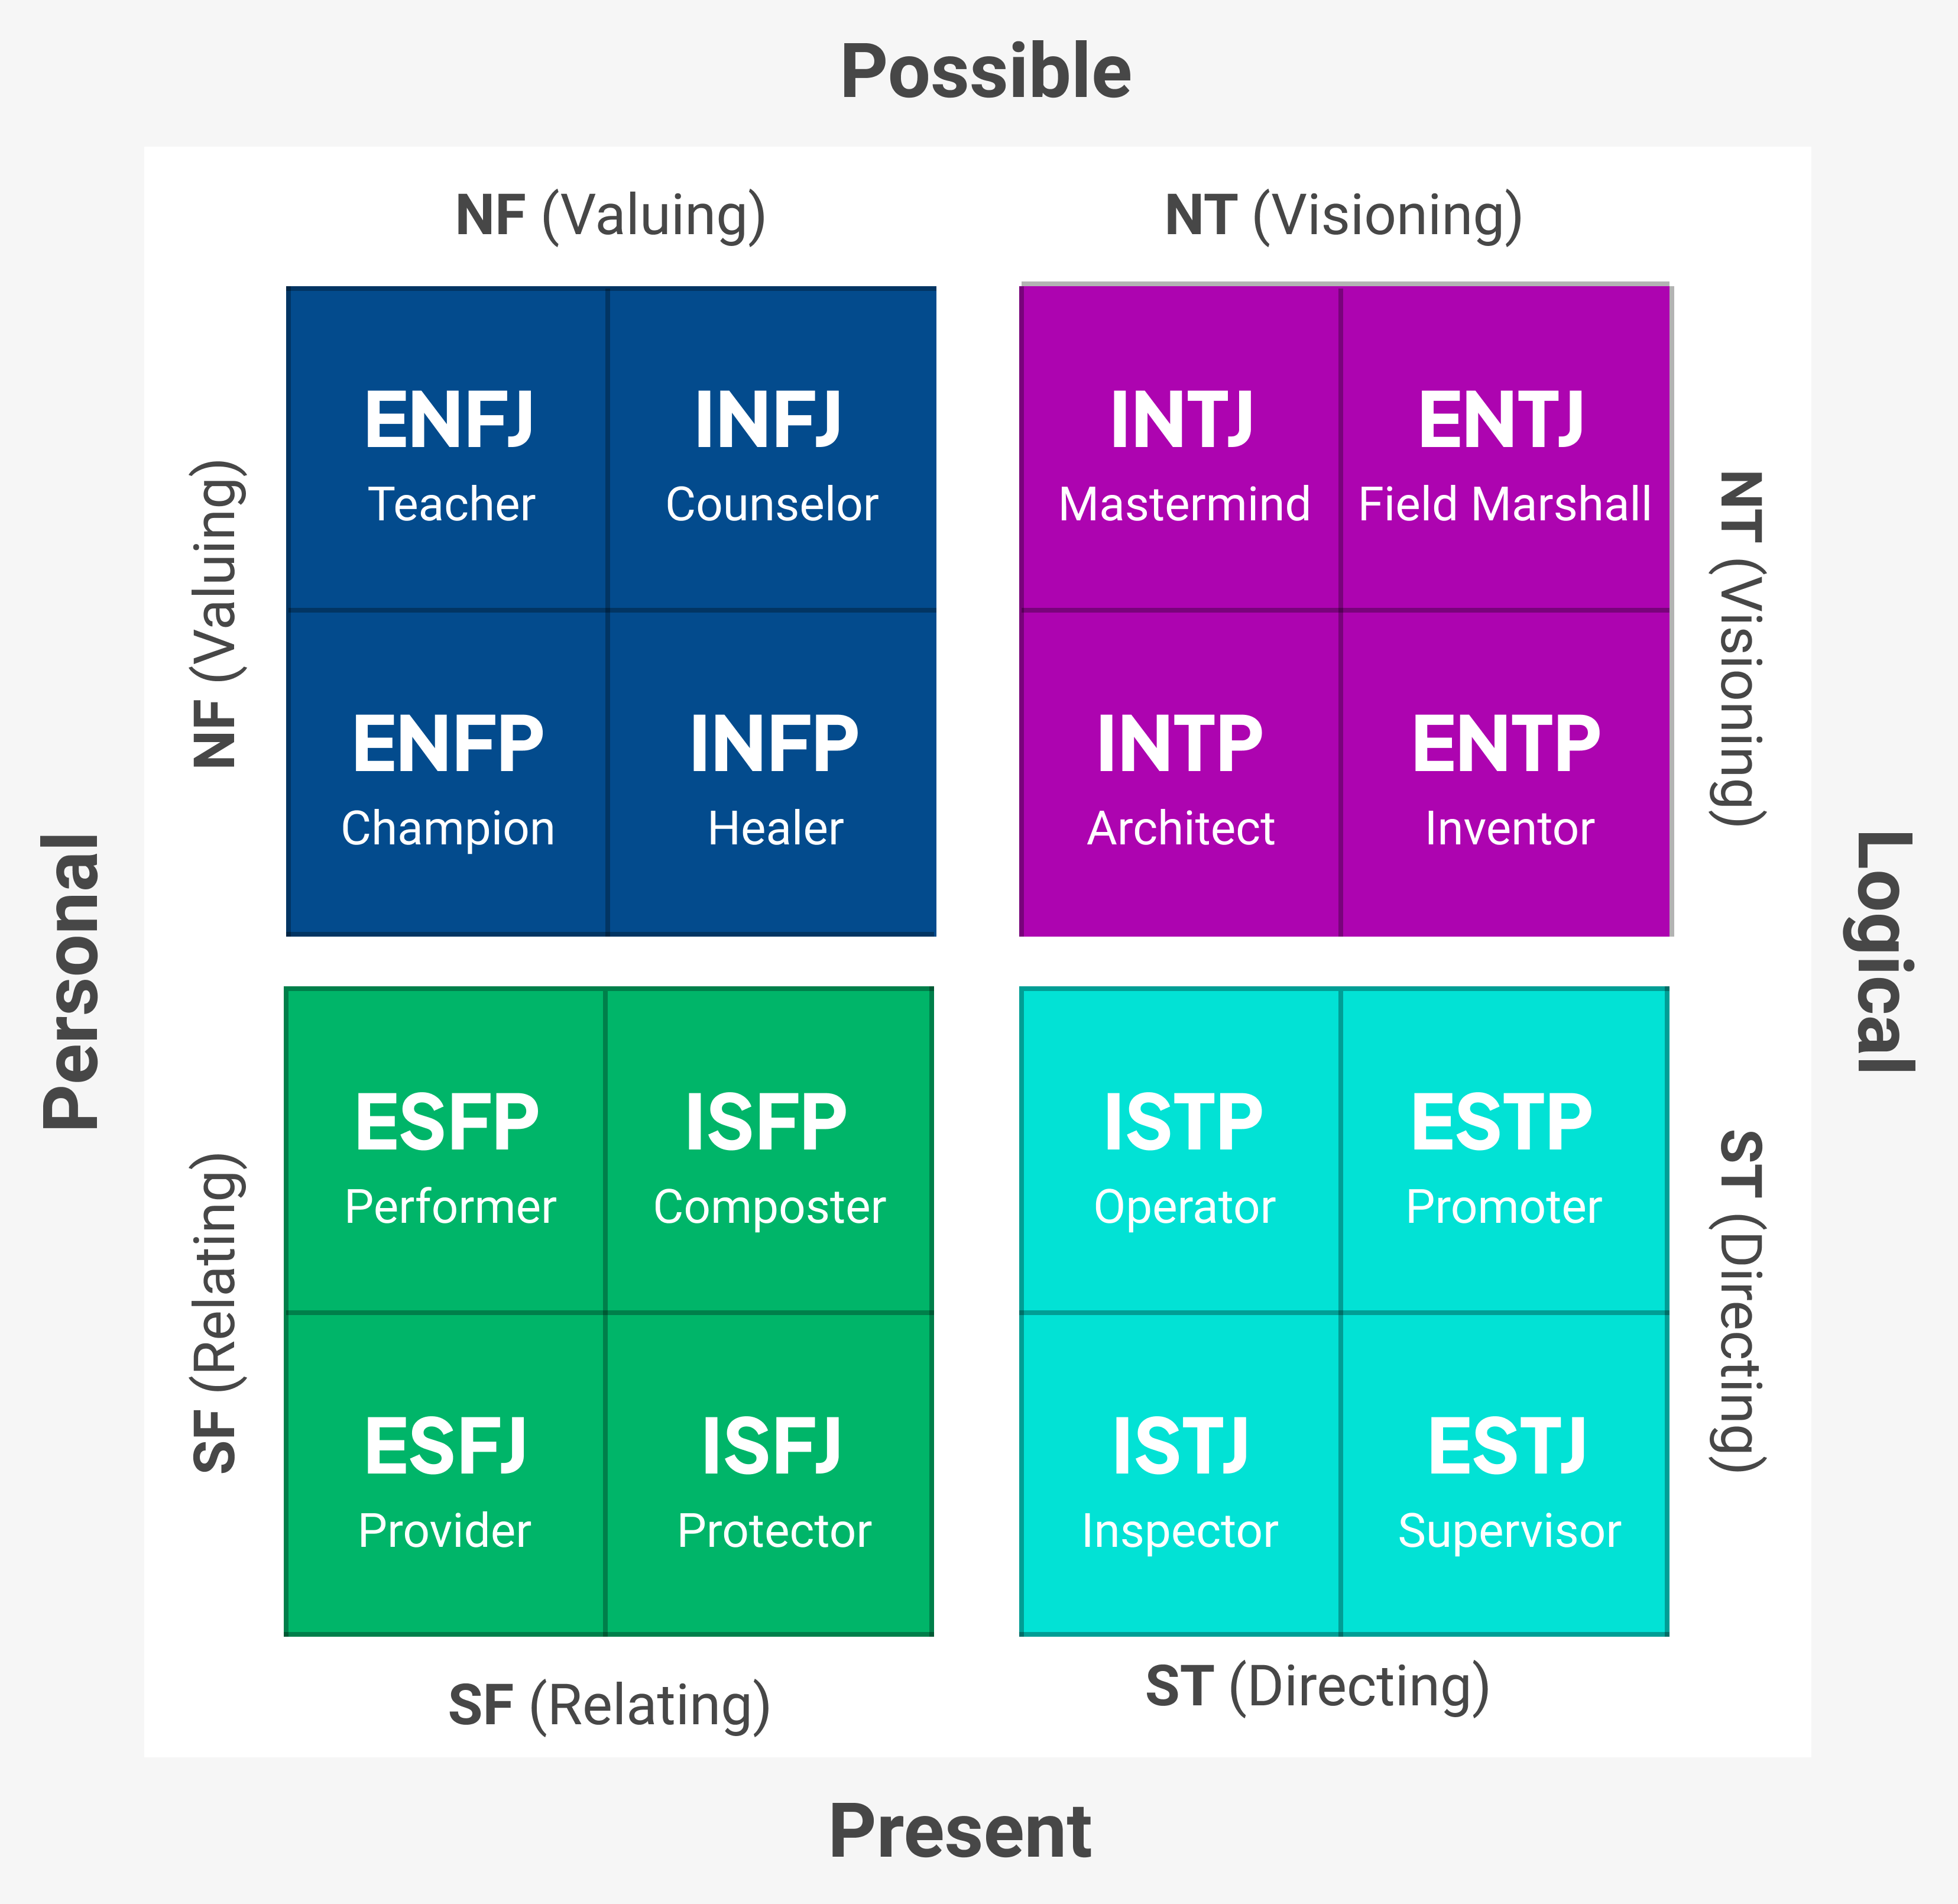

In [38]:
display.Image("mbti_types2.png",width = 600, height = 600)

# Importing Libraries

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import datetime
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from copy import deepcopy
import pprint
import shap
import os
import tensorflow as tf
import catboost
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Importing Dataset

In [40]:
data=pd.read_csv('mbti_1.csv')
data.head()
data.describe(include='O')

type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq    1832                                                  1

In [41]:
data.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

In [42]:
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


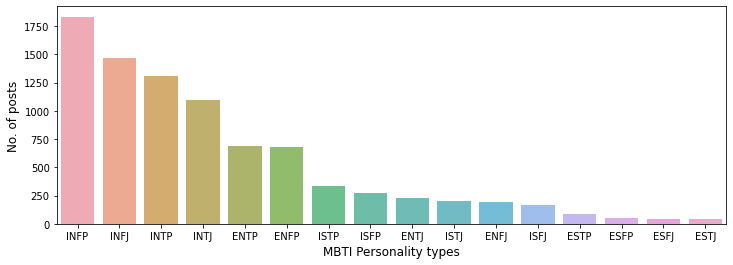

In [44]:
cnt_srs = data['type'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('MBTI Personality types', fontsize=12)
plt.ylabel('No. of posts', fontsize=12)
plt.show()

<AxesSubplot:xlabel='type', ylabel='words_per_comment'>

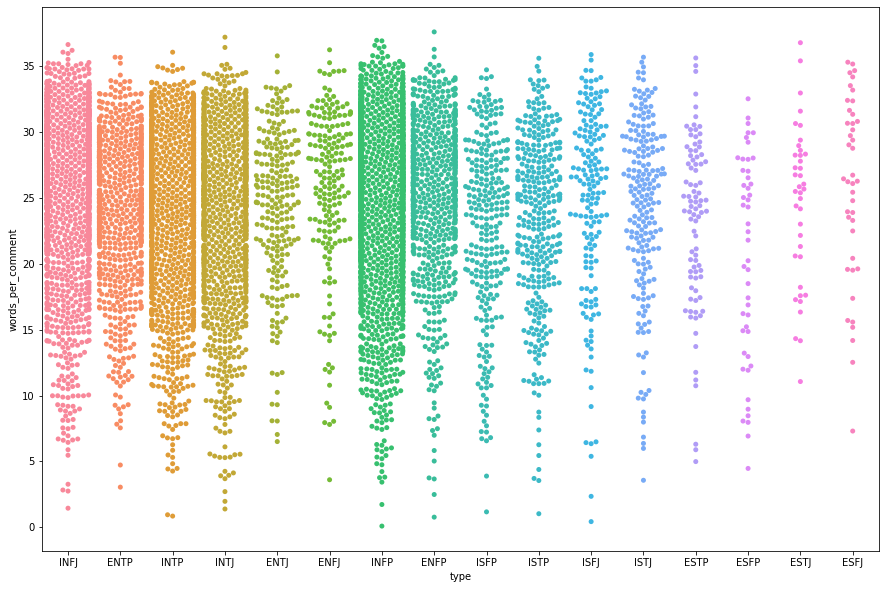

In [9]:
df = data.copy()
#this function counts the no of words in each post of a user
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

#this function counts the no of words per post out of the total 50 posts in the whole row
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))

plt.figure(figsize=(15,10))
sns.swarmplot("type", "words_per_comment", data=df)

<Figure size 1728x360 with 0 Axes>

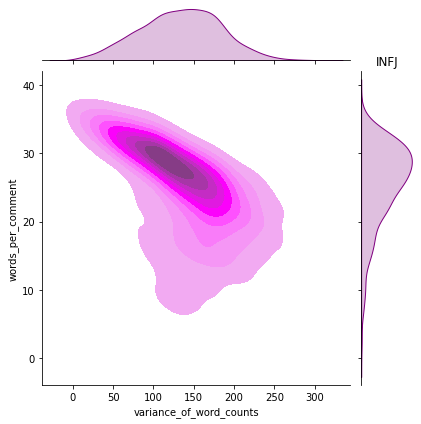

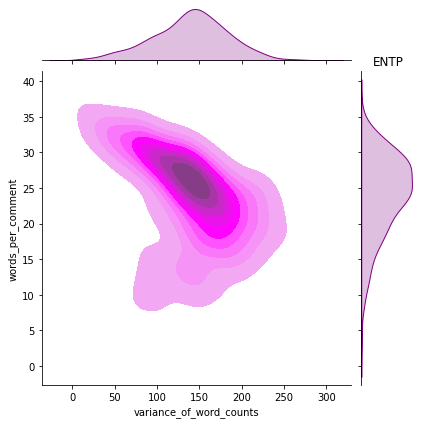

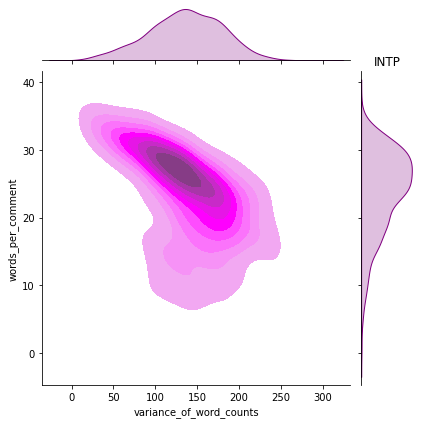

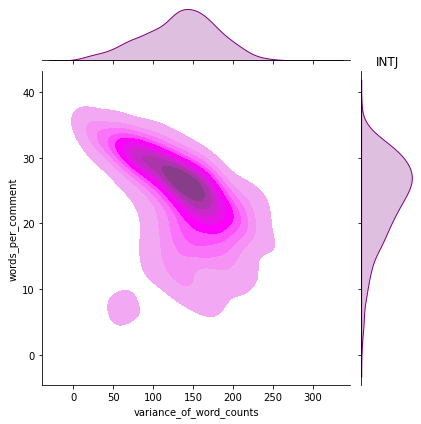

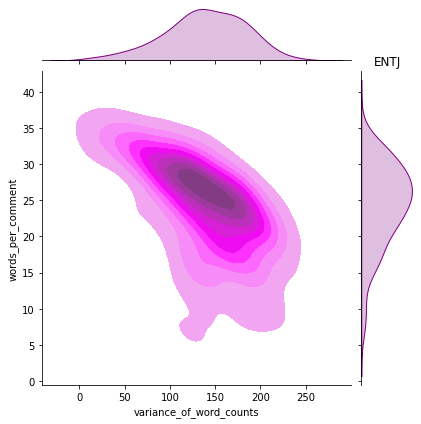

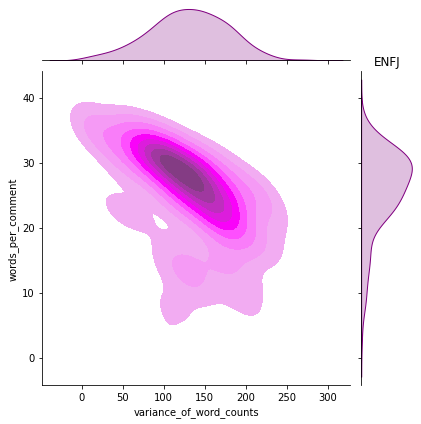

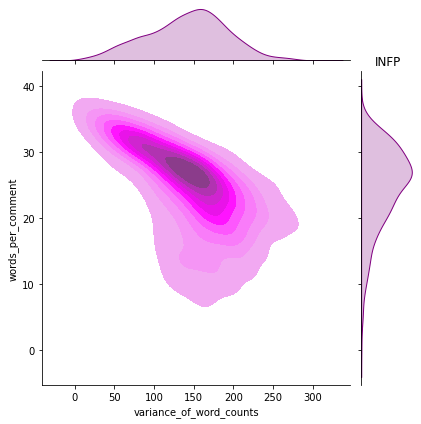

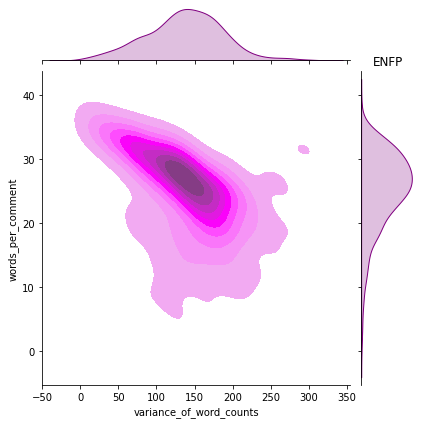

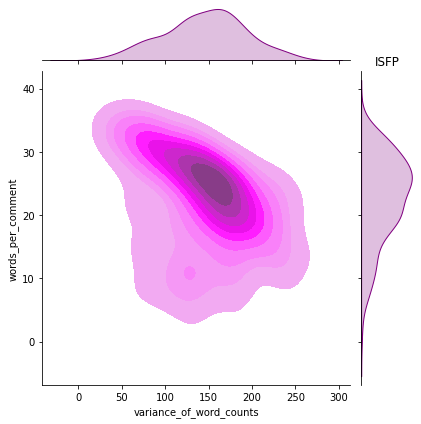

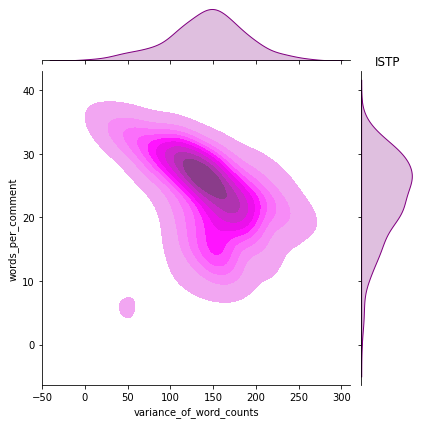

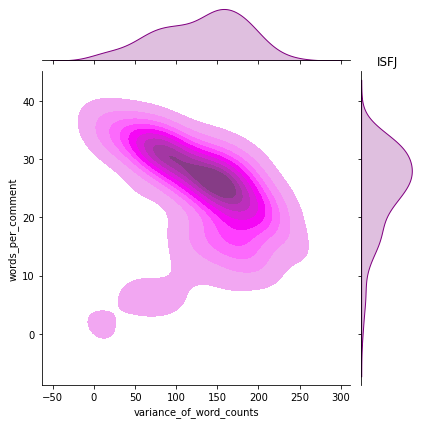

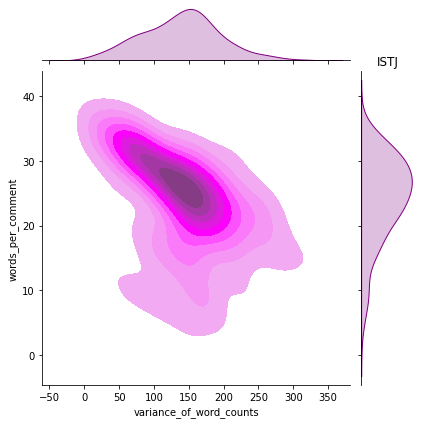

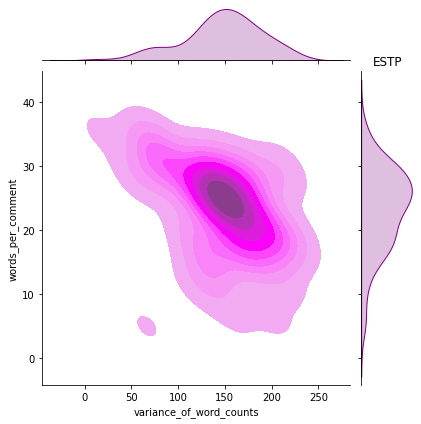

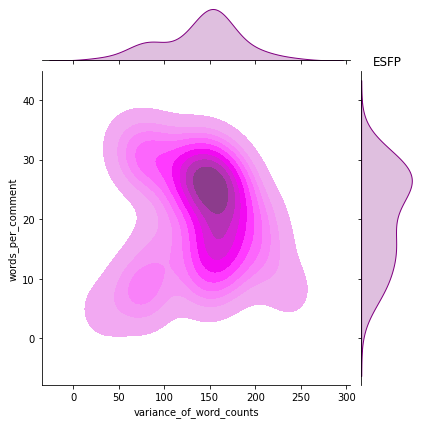

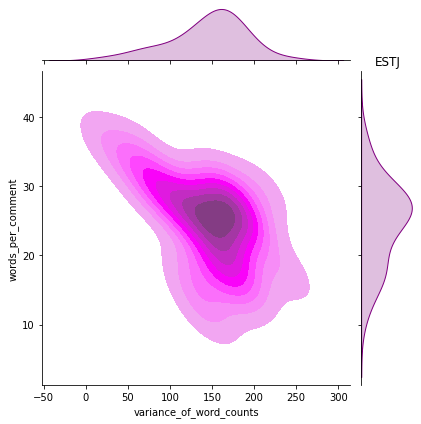

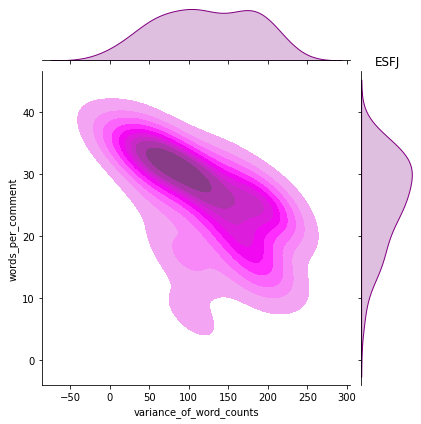

In [10]:
def plot_jointplot(mbti_type, axs, titles):
    df_1 = df[df['type'] == mbti_type]
    sns.jointplot("variance_of_word_counts", "words_per_comment", data=df_1, kind="kde", ax = axs, title = titles)

plt.figure(figsize=(24, 5))    
i = df['type'].unique()
k = 0

for m in range(1,3):
      for n in range(1,9):
        df_1 = df[df['type'] == i[k]]
        sns.jointplot("variance_of_word_counts", "words_per_comment", data=df_1, kind="kde",fill=True,color="purple" )
        plt.title(i[k])
        k+=1
        plt.savefig('kde'+str(m)+'.'+str(n)+'.png')

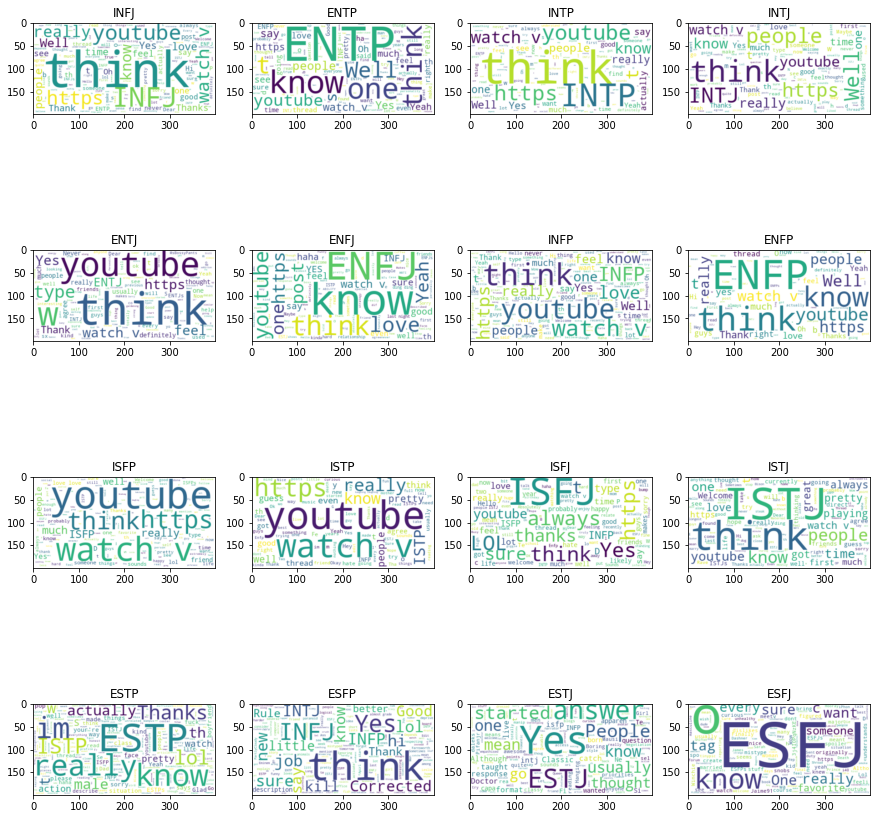

In [11]:
fig, ax = plt.subplots(len(df['type'].unique()), sharex=True, figsize=(15,len(df['type'].unique())))
k = 0
for i in df['type'].unique():
    df_4 = df[df['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False,background_color="white").generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

# Applying Train_Test_Split

for i in range(8675):
    data['type'][i]=data['type'][i][3]
data

In [45]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=0,stratify=data.type)

# Data Pre-processing

In [46]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
#         removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
#         removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [47]:
train_data.posts,train_length=clear_text(train_data)

100%|██████████| 6940/6940 [00:03<00:00, 1946.15it/s]


In [48]:
test_data.posts,test_length=clear_text(test_data)

100%|██████████| 1735/1735 [00:00<00:00, 1956.83it/s]


# Lemmatization

In [49]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

# Term Frequency-Inverse Document Frequency (TF-IDF)

In [50]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)

TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<__main__.Lemmatizer object at 0x0000026454C71688>)

In [51]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [52]:
train_post.shape

(6940, 5000)

In [53]:
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

In [54]:
models_accuracy={}

In [21]:
model_cat=CatBoostClassifier(loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU',learning_rate=0.14,verbose=False)
model_cat.fit(train_post,train_target)
print("Learning Rate is",str(0.14),"   accuracy=",accuracy_score(test_target,model_cat.predict(test_post)))

Learning Rate is 0.14    accuracy= 0.6749279538904899


In [124]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection, svm

auc = 0.793726457548585


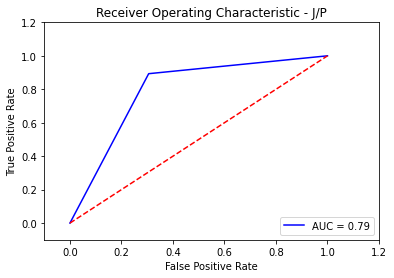

In [125]:
fpr, tpr, thresholds = roc_curve(test_target,model_cat.predict(test_post))
auc = auc(fpr, tpr)
print('auc =', auc)

plt.figure()
plt.title('Receiver Operating Characteristic - J/P')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [55]:
def indac (y,x):
    y=y.astype(np.int)
    y=target_encoder.inverse_transform(y)
    x=target_encoder.inverse_transform(x)
    res=[]
    for i in range(4):
        a=[]
        b=[]
        for j in range(len(y)):
            a.append(x[j][i])
            b.append(y[j][i])
        res.append(accuracy_score(a,b))
    return res

<h4 style="background-color:#00ced1;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Logistic Regression</h4>

In [27]:
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(train_post,train_target)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [41]:
r1=indac(model_log.predict(test_post),test_target)

In [42]:
models_accuracy['logistic regression']=r1

In [43]:
models_accuracy

{'logistic regression': [0.8518731988472622,
  0.8829971181556195,
  0.8368876080691643,
  0.8005763688760807]}

<h4 style="background-color:#00ced1;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Linear Support Vector classifier</h4>

In [44]:
model_linear_svc=LinearSVC(C=0.1)
model_linear_svc.fit(train_post,train_target)

LinearSVC(C=0.1)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_linear_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n',classification_report(test_target,model_linear_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [46]:
r2=indac(model_linear_svc.predict(test_post),test_target)

In [48]:
models_accuracy['Linear Support Vector classifier']=r2
models_accuracy

{'logistic regression': [0.8518731988472622,
  0.8829971181556195,
  0.8368876080691643,
  0.8005763688760807],
 'Linear Support Vector classifier': [0.8599423631123919,
  0.9060518731988473,
  0.8495677233429395,
  0.8138328530259366]}

<h4 style="background-color:##00ced1;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Support Vector classifier</h4>

In [49]:
model_svc=SVC()
model_svc.fit(train_post,train_target)

SVC()

In [ ]:

print('train classification report \n ',classification_report(train_target,model_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [50]:
r3=indac(model_svc.predict(test_post),test_target)

In [51]:
models_accuracy['Support Vector classifier']=r3
models_accuracy

{'logistic regression': [0.8518731988472622,
  0.8829971181556195,
  0.8368876080691643,
  0.8005763688760807],
 'Linear Support Vector classifier': [0.8599423631123919,
  0.9060518731988473,
  0.8495677233429395,
  0.8138328530259366],
 'Support Vector classifier': [0.8570605187319885,
  0.9008645533141211,
  0.8507204610951009,
  0.8046109510086455]}

<h4 style="background-color:#00ced1;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Multinomial Naive Bayes</h4>

In [52]:
model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(train_post,train_target)

MultinomialNB()

In [23]:
r4=indac(model_multinomial_nb.predict(test_post),test_target)

NameError: name 'indac' is not defined

In [ ]:

print('train classification report \n ',classification_report(train_target,model_multinomial_nb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_multinomial_nb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [ ]:
models_accuracy['Multinomial Naive Bayes']=r4
models_accuracy

<h4 style="background-color:#00ced1;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">XGBoost Classifier</h4>

In [62]:
model_xgb=XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.8)
model_xgb.fit(train_post,train_target)

[02:38:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.8, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [63]:
print('train classification report \n ',classification_report(train_target,model_xgb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_xgb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       1.00      1.00      1.00       152
        ENFP       1.00      1.00      1.00       540
        ENTJ       1.00      1.00      1.00       185
        ENTP       1.00      1.00      1.00       548
        ESFJ       1.00      1.00      1.00        34
        ESFP       1.00      1.00      1.00        38
        ESTJ       1.00      1.00      1.00        31
        ESTP       1.00      1.00      1.00        71
        INFJ       1.00      1.00      1.00      1176
        INFP       1.00      1.00      1.00      1465
        INTJ       1.00      1.00      1.00       873
        INTP       1.00      1.00      1.00      1043
        ISFJ       1.00      1.00      1.00       133
        ISFP       1.00      1.00      1.00       217
        ISTJ       1.00      1.00      1.00       164
        ISTP       1.00      1.00      1.00       270

    accuracy                           1.00      

In [64]:
r5=indac(model_xgb.predict(test_post),test_target)

In [65]:
models_accuracy['XGBoost Classifier']=r5
models_accuracy

{'XGBoost Classifier': [0.8576368876080691,
  0.9106628242074928,
  0.8144092219020173,
  0.8023054755043227]}

<h4 style="background-color:#00ced1;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">CatBoost Classifier</h4>

In [21]:
model_cat=CatBoostClassifier(loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU',learning_rate=0.14,verbose=False)
model_cat.fit(train_post,train_target)
print("Learning Rate is",str(0.14),"   accuracy=",accuracy_score(test_target,model_cat.predict(test_post)))

Learning Rate is 0.14    accuracy= 0.6818443804034582


In [22]:
model_cat.get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'MultiClass',
 'iterations': 1000,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'grow_policy': 'SymmetricTree',
 'boosting_type': 'Plain',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.1000000015,
 'devices': '-1',
 'pinned_memory_bytes': '104857600',
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'fold_size_loss_normalization': False,
 'gpu_cat_features_storage': 'GpuRam',
 'use_best_model': False,
 'class_names': ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15'],
 'random_seed': 0,
 'depth': 6,
 'has_time': False,
 'fold_len_multiplier': 2,
 'border_count': 128,
 'min_fold_size': 100,
 'data_partition': 'DocParallel',
 'bagging_temperature': 1,
 'classes_count': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees':

In [23]:
#Learning Rate is 0.14    accuracy= 0.6818443804034582
print('train classification report \n ',classification_report(train_target,model_cat.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_cat.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.91      0.66      0.77       152
        ENFP       0.85      0.81      0.83       540
        ENTJ       0.91      0.69      0.78       185
        ENTP       0.85      0.83      0.84       548
        ESFJ       1.00      0.53      0.69        34
        ESFP       1.00      0.42      0.59        38
        ESTJ       1.00      0.48      0.65        31
        ESTP       0.96      0.73      0.83        71
        INFJ       0.86      0.88      0.87      1176
        INFP       0.83      0.92      0.87      1465
        INTJ       0.84      0.86      0.85       873
        INTP       0.81      0.90      0.85      1043
        ISFJ       0.92      0.72      0.81       133
        ISFP       0.84      0.72      0.78       217
        ISTJ       0.89      0.76      0.82       164
        ISTP       0.90      0.84      0.87       270

    accuracy                           0.85      

In [24]:
r6=indac(model_cat.predict(test_post),test_target)
models_accuracy['CatBoost Classifier']=r6

NameError: name 'indac' is not defined

In [ ]:
models_accuracy

In [ ]:
x=test_target
y=model_cat.predict(test_post)
y=y.astype(np.int)
y=target_encoder.inverse_transform(y)
x=target_encoder.inverse_transform(x)


In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection, svm

In [28]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

ValueError: multiclass format is not supported

In [82]:
for i in models_accuracy:
    for j in range(4):
        models_accuracy[i][j]*=100

{'logistic regression': [85.18731988472622,
  88.29971181556195,
  83.68876080691643,
  80.05763688760807],
 'Linear Support Vector classifier': [85.99423631123919,
  90.60518731988473,
  84.95677233429394,
  81.38328530259365],
 'Support Vector classifier': [85.70605187319885,
  90.08645533141211,
  85.0720461095101,
  80.46109510086455],
 'Multinomial Naive Bayes': [77.52161383285303,
  86.22478386167147,
  70.60518731988472,
  67.89625360230548],
 'XGBoost Classifier': [86.51296829971182,
  90.37463976945244,
  84.3227665706052,
  82.2478386167147],
 'CatBoost Classifier': [87.60806916426513,
  91.06628242074927,
  84.55331412103746,
  82.9971181556196]}

In [83]:
results=pd.DataFrame(models_accuracy)
results

logistic regression  Linear Support Vector classifier  \
0            85.187320                         85.994236   
1            88.299712                         90.605187   
2            83.688761                         84.956772   
3            80.057637                         81.383285   

   Support Vector classifier  Multinomial Naive Bayes  XGBoost Classifier  \
0                  85.706052                77.521614           86.512968   
1                  90.086455                86.224784           90.374640   
2                  85.072046                70.605187           84.322767   
3                  80.461095                67.896254           82.247839   

   CatBoost Classifier  
0            87.608069  
1            91.066282  
2            84.553314  
3            82.997118

In [92]:
existing_works={'Naïve Bayes':[77.12,86.52,77.32,62.63],'Neural Network':[77.35,86.43,54.37,61.91],'SVM':[73.91,79.86,81.63,77.24],'Xgboost':[78.27,86.26,71.89,65.50],'Catboost':[87.61,91.07,84.55,83.00]}
ex_works_results=pd.DataFrame(existing_works)
ex_works_results

Naïve Bayes  Neural Network    SVM  Xgboost  Catboost
0        77.12           77.35  73.91    78.27     87.61
1        86.52           86.43  79.86    86.26     91.07
2        77.32           54.37  81.63    71.89     84.55
3        62.63           61.91  77.24    65.50     83.00

In [1]:
import plotly.graph_objects as go

categories = ['Introversion (I)–Extraversion (E)','Intuition (N)–Sensing (S)','Feeling (F)–Thinking (T)',
              'Judging (J)–Perceiving (P)']

fig = go.Figure()
fig.add_trace(go.Scatterpolar(
      r=[77.12,86.52,77.32,62.63],
      theta=categories,
      #fill='toself',
      name='Naive Bayes'
))
fig.add_trace(go.Scatterpolar(
      r=[77.35,86.43,54.37,61.91],
      theta=categories,
      #fill='toself',
      name='Neural Network'
    
))
fig.add_trace(go.Scatterpolar(
      r=[73.91,79.86,81.63,77.24],
      theta=categories,
      #fill='toself',
      name='SVM'
))
fig.add_trace(go.Scatterpolar(
      r=[78.27,86.26,71.89,65.50],
      theta=categories,
      #fill='toself',
      name='Xgboost'
))
fig.add_trace(go.Scatterpolar(
      r=[87.61,91.07,84.55,83.00],
      theta=categories,
      #fill='toself',
      name='Catboost'
))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,100]
    )),
  showlegend=True
)

fig.show()